In [65]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from operator import itemgetter

# Parámetros iniciales
lamb = 1 / 300  # Tasa promedio de llegadas (lambda)
num_onu = 15  # Cantidad de ONUs
ancho_banda_total = 1244.0  # Ancho de banda total en Mbps para upstream
lat_min = 20.0  # Latencia mínima
lat_max = 100.0  # Latencia máxima
utility = np.zeros(num_onu, dtype=int)
package = 15000  # Tamaño de un paquete de datos en bits

In [62]:
# Solicitudes iniciales en bits
np.random.seed(42)
mu = np.log(200**2 / np.sqrt(20**2 + 200**2))
sigma = np.sqrt(np.log(1 + (20**2 / 200**2)))

In [59]:
def dba_upstream():
    # Solicitudes de las ONUs (prioridad EF, AF y BE)
    demandas_ef = np.random.lognormal(mu, sigma, num_onu)  # Expedited Forwarding
    demandas_af = np.random.lognormal(mu, sigma, num_onu)  # Assured Forwarding
    demandas_be = np.random.lognormal(mu, sigma, num_onu)  # Best Effort

    # Inicializar asignaciones de ancho de banda
    G_H = np.zeros(num_onu)  # Asignaciones EF
    G_M = np.zeros(num_onu)  # Asignaciones AF
    G_L = np.zeros(num_onu)  # Asignaciones BE

    # Ciclo fijo: Asignar ancho de banda a EF (40% del total disponible)
    for i in range(num_onu):
        G_H[i] = min(demandas_ef[i], ancho_banda_total * 0.4 / num_onu)

    # Calcular el ancho de banda restante para AF y BE
    ancho_restante = ancho_banda_total - np.sum(G_H)

    # Distribuir ancho restante entre AF y BE
    if ancho_restante > 0:
        demandas_totales = demandas_af + demandas_be
        proporciones_af = demandas_af / demandas_totales
        proporciones_be = demandas_be / demandas_totales

        for i in range(num_onu):
            G_M[i] = min(proporciones_af[i] * ancho_restante, demandas_af[i])
            G_L[i] = min(proporciones_be[i] * ancho_restante, demandas_be[i])

    # Calcular métricas
    latencias = (demandas_ef / G_H) * lat_min + np.random.uniform(0.1, 1.0, num_onu)
    paquetes_transmitidos = (G_H + G_M + G_L) / package
    paquetes_demandados = (demandas_ef + demandas_af + demandas_be) / package
    perdidas_paquetes = ((paquetes_demandados - paquetes_transmitidos) / paquetes_demandados) * 100

    # Actualizar la utilidad de la ONU con mayor demanda
    utility[np.argmax(demandas_ef)] += 1

    # Retornar métricas y demandas/asignaciones
    solicitado = np.stack((demandas_ef, demandas_af, demandas_be), axis=-1)  # Solicitudes EF, AF, BE
    asignado = np.stack((G_H, G_M, G_L), axis=-1)  # Asignaciones EF, AF, BE
    return latencias, perdidas_paquetes, solicitado, asignado


In [58]:
def simulacion_upstream():
    llegadas = 0
    latencias_totales = np.zeros(num_onu)
    perdidas_totales = np.zeros(num_onu)
    promedios_latencias = []
    promedios_perdida = []

    solicitado_total = []
    asignado_total = []

    while llegadas < 10**6:  # Simular hasta 1 millón de llegadas
        latencias, perdida, solicitado, asignado = dba_upstream()
        latencias_totales += latencias
        perdidas_totales += perdida
        llegadas += 1

        solicitado_total.append(solicitado)  # Acumular solicitudes
        asignado_total.append(asignado)  # Acumular asignaciones

        # Cada 100,000 llegadas calcular promedios
        if llegadas % 100000 == 0:
            promedio_latencia = latencias_totales / 100000
            promedios_latencias.append(promedio_latencia.copy())
            latencias_totales = np.zeros(num_onu)

            promedio_perdida = perdidas_totales / 100000
            promedios_perdida.append(promedio_perdida.copy())
            perdidas_totales = np.zeros(num_onu)

    # Convertir acumuladores a arreglos para gráficas
    solicitado_total = np.array(solicitado_total)  # Dimensión: [iteraciones, num_onu, 3]
    asignado_total = np.array(asignado_total)  # Dimensión: [iteraciones, num_onu, 3]
    promedios_latencias = np.array(promedios_latencias)
    promedios_perdida = np.array(promedios_perdida)

    print("Máxima demanda por ONU:", utility)

    # Visualización de resultados
    metricas(promedios_latencias, promedios_perdida)  # Latencia y pérdida de paquetes
    metricas_ef_af_be(solicitado_total, asignado_total)  # Ancho de banda solicitado y asignado


In [61]:
def metricas(promedios_latencias, promedios_perdida):
    # Gráfico 1: Latencia Promedio
    for onu in range(promedios_latencias.shape[1]):  # Iterar sobre cada ONU
        plt.plot(promedios_latencias[:, onu], label=f'ONU {onu + 1}')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Latencia Promedio (ms)')
    plt.title('Latencia Promedio de cada ONU por Llegadas/10^6')
    plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Pérdida Promedio de Paquetes
    for onu in range(promedios_perdida.shape[1]):  # Iterar sobre cada ONU
        plt.plot(promedios_perdida[:, onu], label=f'ONU {onu + 1}')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Pérdida Promedio de Paquetes (%)')
    plt.title('Pérdida Promedio de Paquetes de cada ONU por Llegadas/10^6')
    plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
    plt.tight_layout()
    plt.show()


In [60]:
def metricas_ef_af_be(solicitado, asignado):
    # Gráfico 1: Solicitado por EF, AF y BE
    for onu in range(solicitado.shape[1]):
        plt.plot(solicitado[:, onu, 0], label=f'EF Solicitado - ONU {onu + 1}')
        plt.plot(solicitado[:, onu, 1], label=f'AF Solicitado - ONU {onu + 1}', linestyle='--')
        plt.plot(solicitado[:, onu, 2], label=f'BE Solicitado - ONU {onu + 1}', linestyle='-.')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Ancho de Banda Solicitado (Mbps)')
    plt.title('Ancho de Banda Solicitado por EF, AF y BE (Por ONU)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # Gráfico 2: Asignado por EF, AF y BE
    for onu in range(asignado.shape[1]):
        plt.plot(asignado[:, onu, 0], label=f'EF Asignado - ONU {onu + 1}')
        plt.plot(asignado[:, onu, 1], label=f'AF Asignado - ONU {onu + 1}', linestyle='--')
        plt.plot(asignado[:, onu, 2], label=f'BE Asignado - ONU {onu + 1}', linestyle='-.')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Ancho de Banda Asignado (Mbps)')
    plt.title('Ancho de Banda Asignado por EF, AF y BE (Por ONU)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # Gráfico 3: Comparación entre Solicitado y Asignado para EF, AF y BE
    for onu in range(solicitado.shape[1]):
        plt.plot(solicitado[:, onu, 0], label=f'EF Solicitado - ONU {onu + 1}', color='blue')
        plt.plot(asignado[:, onu, 0], label=f'EF Asignado - ONU {onu + 1}', linestyle='--', color='blue')
        plt.plot(solicitado[:, onu, 1], label=f'AF Solicitado - ONU {onu + 1}', color='green')
        plt.plot(asignado[:, onu, 1], label=f'AF Asignado - ONU {onu + 1}', linestyle='--', color='green')
        plt.plot(solicitado[:, onu, 2], label=f'BE Solicitado - ONU {onu + 1}', color='orange')
        plt.plot(asignado[:, onu, 2], label=f'BE Asignado - ONU {onu + 1}', linestyle='--', color='orange')
    plt.xlabel('Llegadas (10^6)')
    plt.ylabel('Ancho de Banda (Mbps)')
    plt.title('Comparación de Solicitado vs Asignado por EF, AF y BE')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


Máxima demanda por ONU: [66407 67404 66971 66780 66759 66589 66733 66729 66516 67014 66159 66293
 66637 66619 66390]


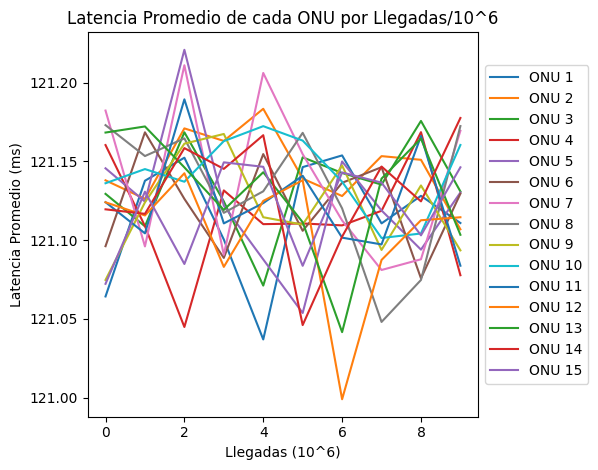

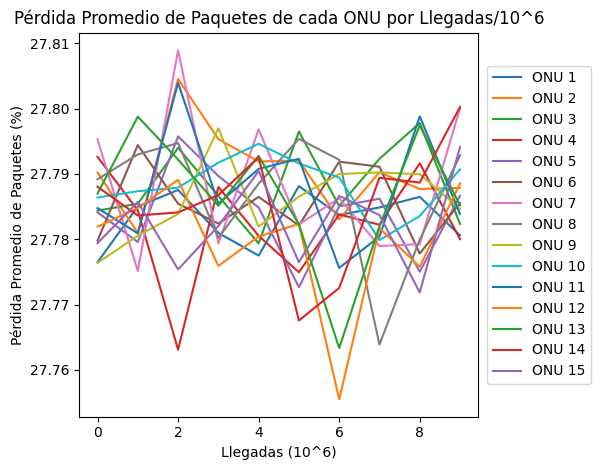

C:\Users\aceve\AppData\Local\Temp\ipykernel_28176\528359040.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


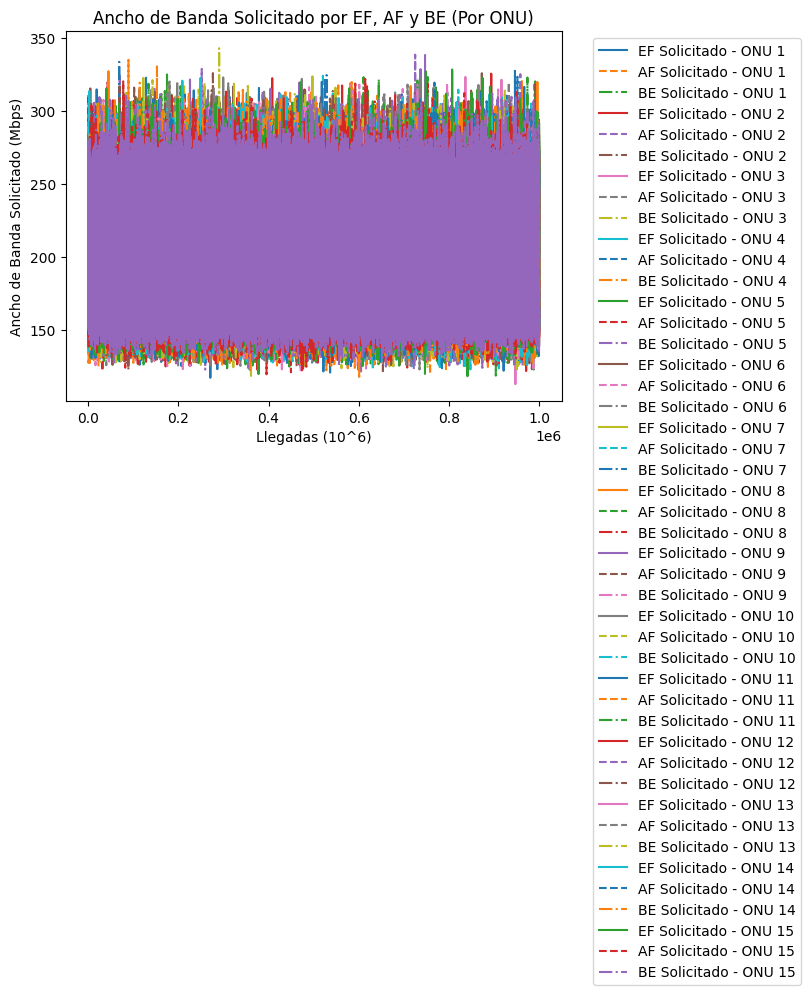

C:\Users\aceve\AppData\Local\Temp\ipykernel_28176\528359040.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


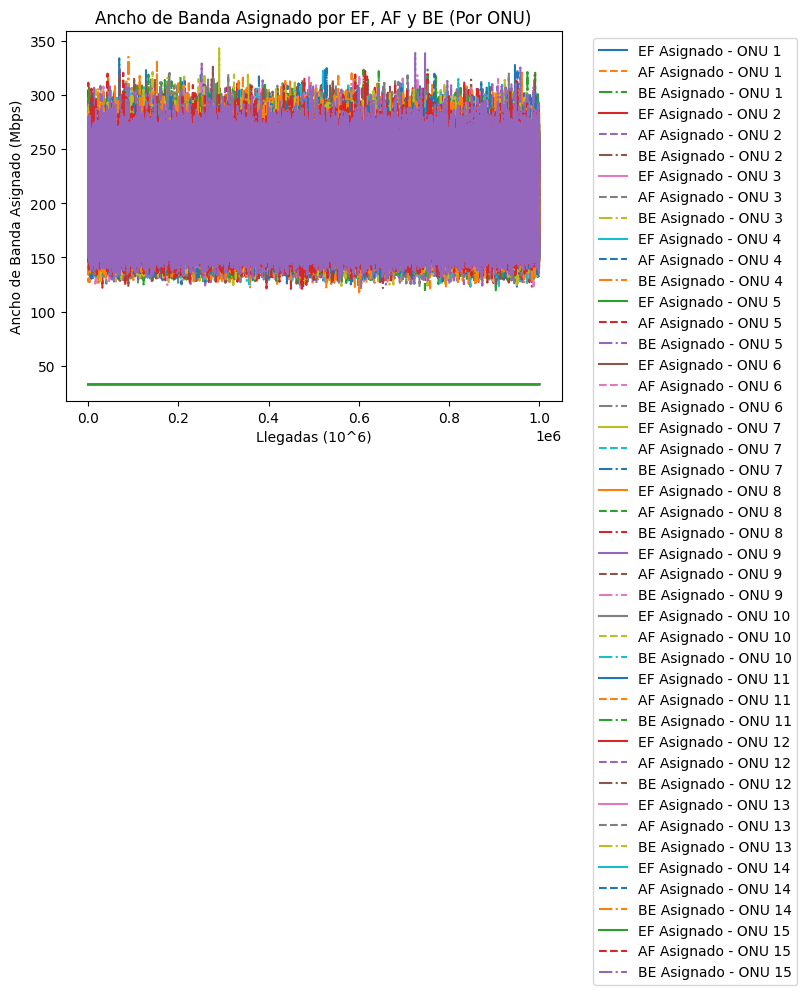

C:\Users\aceve\AppData\Local\Temp\ipykernel_28176\528359040.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


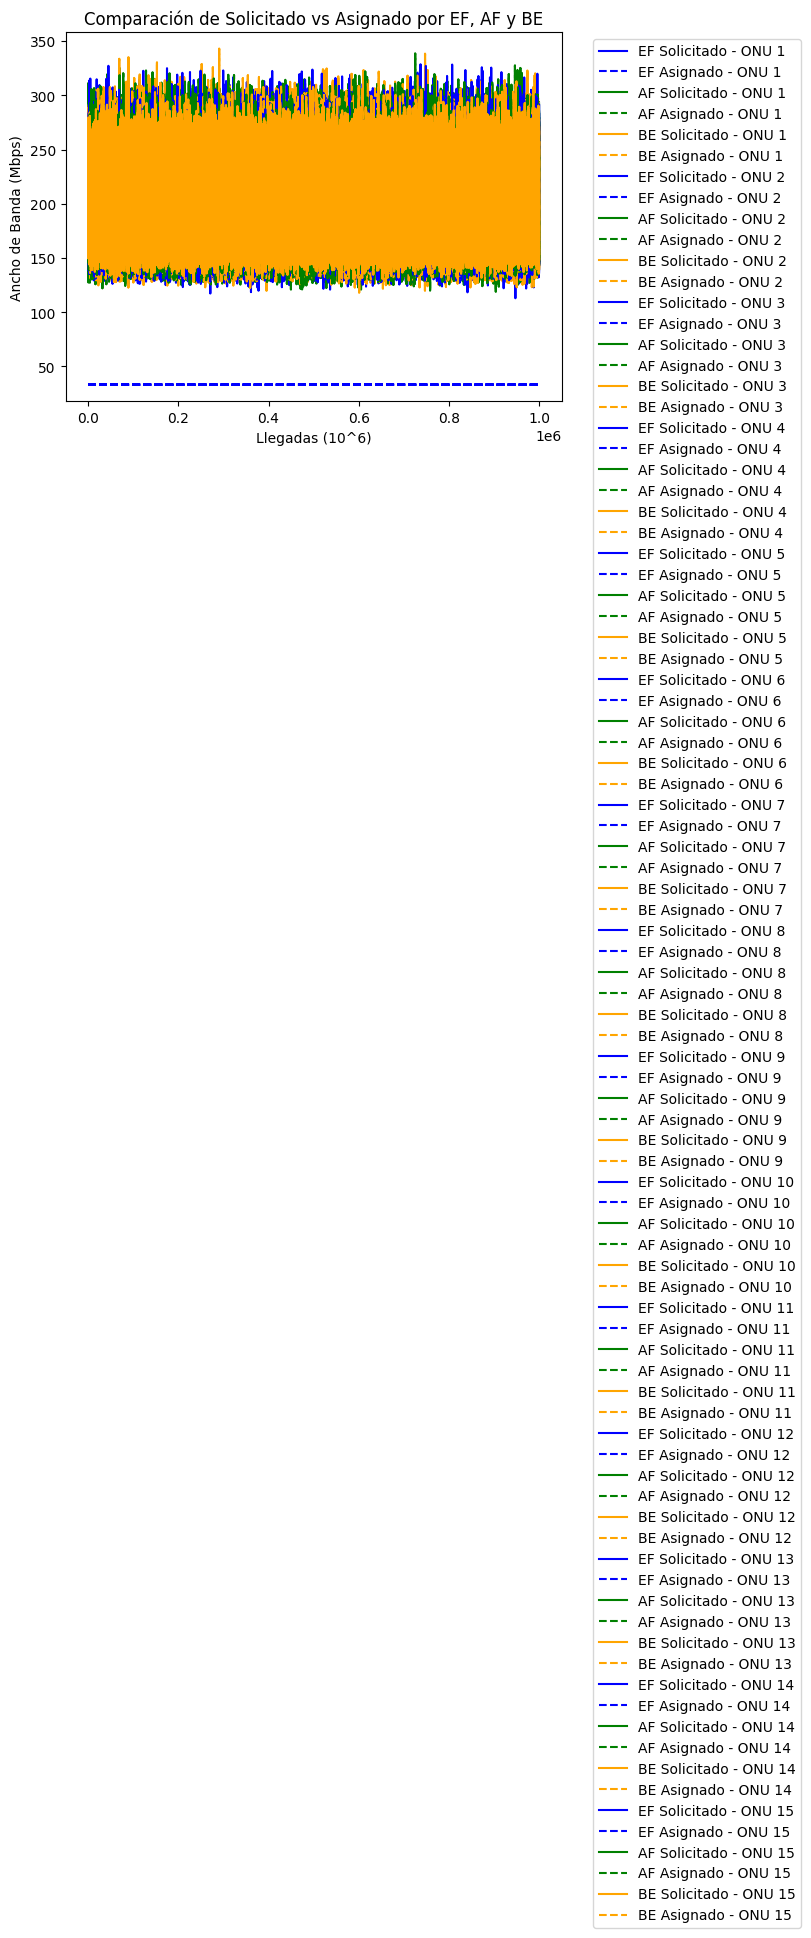

In [66]:
simulacion_upstream()